In [1]:
import pandas as pd
import os
import numpy as np
import pydicom
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob             
from tqdm.notebook import tqdm
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.set_option('display.max_columns', None) # display all columns in this notebook
pd.set_option('display.max_rows', 100) # increase number of displayed rows
pd.set_option('max_colwidth', None) # make full cells content visible

In [3]:
DATA_DIR = "/kaggle/input/rsna-intracranial-aneurysm-detection/"
SEGMENTATION_DIR = os.path.join(DATA_DIR, "segmentation")
SERIES_DIR = os.path.join(DATA_DIR, "series")

In [4]:
# CSV files
#  Load and Inspect CSV Data
print("Loading and Inspecting CSV Data")
train_df = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
localizers_df = pd.read_csv(os.path.join(DATA_DIR, "train_localizers.csv"))
print(f"Loaded {len(train_df)} rows from train.csv")
print(f"Loaded {len(localizers_df)} rows from train_localizers.csv")
print("\n--- train.csv head ---")
display(train_df.head())
print("\n--- train_localizers.csv head ---")
display(localizers_df.head())

Loading and Inspecting CSV Data
Loaded 4405 rows from train.csv
Loaded 2286 rows from train_localizers.csv

--- train.csv head ---


,SeriesInstanceUID,PatientAge,PatientSex,Modality,Left Infraclinoid Internal Carotid Artery,Right Infraclinoid Internal Carotid Artery,Left Supraclinoid Internal Carotid Artery,Right Supraclinoid Internal Carotid Artery,Left Middle Cerebral Artery,Right Middle Cerebral Artery,Anterior Communicating Artery,Left Anterior Cerebral Artery,Right Anterior Cerebral Artery,Left Posterior Communicating Artery,Right Posterior Communicating Artery,Basilar Tip,Other Posterior Circulation,Aneurysm Present
0,1.2.826.0.1.3680043.8.498.10004044428023505108375152878107656647,64,Female,MRA,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.2.826.0.1.3680043.8.498.10004684224894397679901841656954650085,76,Female,MRA,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317,58,Male,CTA,0,0,0,0,0,0,0,0,0,0,0,0,1,1
3,1.2.826.0.1.3680043.8.498.10009383108068795488741533244914370182,71,Male,MRA,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.8.498.10012790035410518400400834395242853657,48,Female,MRA,0,0,0,0,0,0,0,0,0,0,0,0,0,0



--- train_localizers.csv head ---


,SeriesInstanceUID,SOPInstanceUID,coordinates,location
0,1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317,1.2.826.0.1.3680043.8.498.10775329348174902199350466348663848346,"{'x': 258.3621186176837, 'y': 261.359900373599}",Other Posterior Circulation
1,1.2.826.0.1.3680043.8.498.10022796280698534221758473208024838831,1.2.826.0.1.3680043.8.498.53868409774237283281776807176852774246,"{'x': 194.87253141831238, 'y': 178.32675044883302}",Right Middle Cerebral Artery
2,1.2.826.0.1.3680043.8.498.10023411164590664678534044036963716636,1.2.826.0.1.3680043.8.498.24186535344744886473554579401056227253,"{'x': 189.23979878597123, 'y': 209.19184886465828}",Right Middle Cerebral Artery
3,1.2.826.0.1.3680043.8.498.10030095840917973694487307992374923817,1.2.826.0.1.3680043.8.498.75217084841854214544099244823406151875,"{'x': 208.2805049088359, 'y': 229.78962131837307}",Right Infraclinoid Internal Carotid Artery
4,1.2.826.0.1.3680043.8.498.10034081836061566510187499603024895557,1.2.826.0.1.3680043.8.498.71237104731452368587327801789352569583,"{'x': 249.86745590416498, 'y': 220.623044646393}",Anterior Communicating Artery


In [5]:
print(train_df.columns)
print(localizers_df.columns)

Index(['SeriesInstanceUID', 'PatientAge', 'PatientSex', 'Modality',
       'Left Infraclinoid Internal Carotid Artery',
       'Right Infraclinoid Internal Carotid Artery',
       'Left Supraclinoid Internal Carotid Artery',
       'Right Supraclinoid Internal Carotid Artery',
       'Left Middle Cerebral Artery', 'Right Middle Cerebral Artery',
       'Anterior Communicating Artery', 'Left Anterior Cerebral Artery',
       'Right Anterior Cerebral Artery', 'Left Posterior Communicating Artery',
       'Right Posterior Communicating Artery', 'Basilar Tip',
       'Other Posterior Circulation', 'Aneurysm Present'],
      dtype='object')
Index(['SeriesInstanceUID', 'SOPInstanceUID', 'coordinates', 'location'], dtype='object')



--- 2. Statistical Analysis and Visualization of CSV Data ---


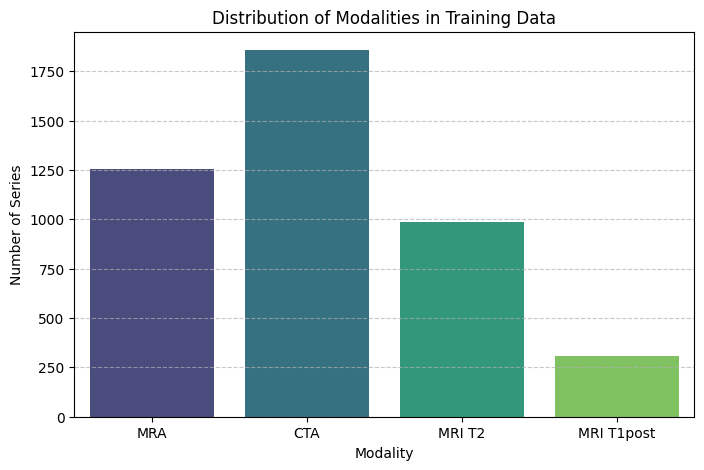

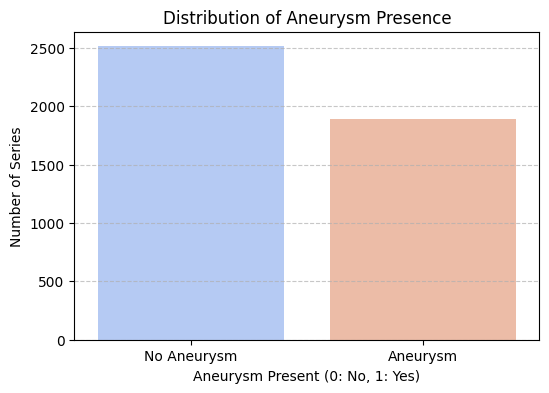

In [6]:
# --- 2. Statistical Analysis and Visualization of CSV Data ---
print("\n--- 2. Statistical Analysis and Visualization of CSV Data ---")

# Modality Distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=train_df, x='Modality', palette='viridis')
plt.title('Distribution of Modalities in Training Data')
plt.xlabel('Modality')
plt.ylabel('Number of Series')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Aneurysm Presence Distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=train_df, x='Aneurysm Present', palette='coolwarm')
plt.title('Distribution of Aneurysm Presence')
plt.xlabel('Aneurysm Present (0: No, 1: Yes)')
plt.ylabel('Number of Series')
plt.xticks([0, 1], ['No Aneurysm', 'Aneurysm'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


IMAGING MODALITY ANALYSIS
Modality Distribution:
Modality
CTA           1857
MRA           1256
MRI T2         986
MRI T1post     306
Name: count, dtype: int64


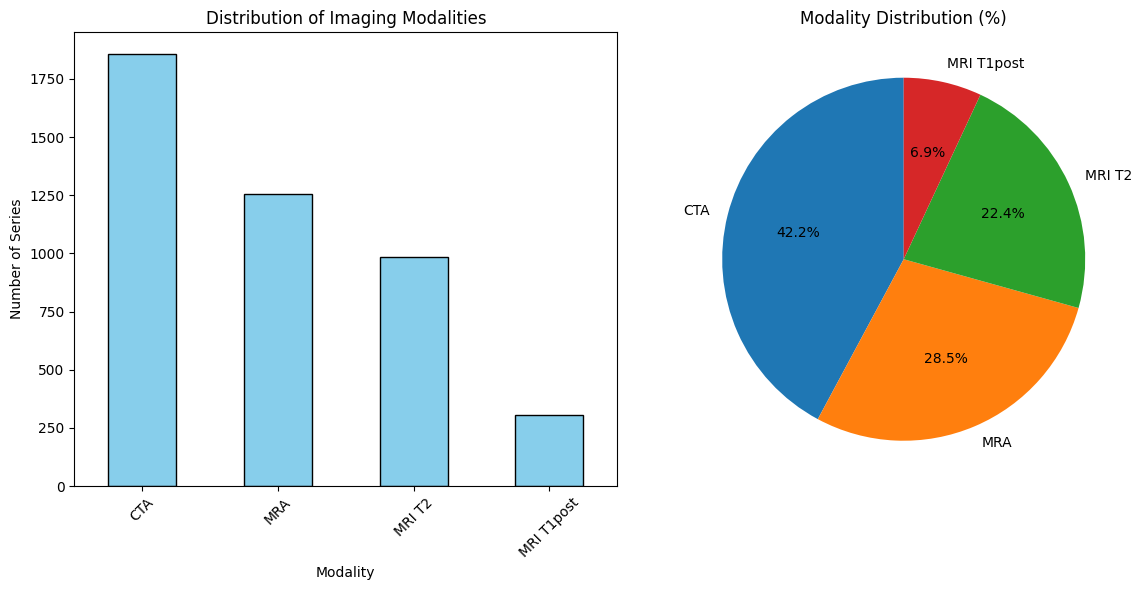

In [7]:
# 6. Analyze modalities
def analyze_modality_distribution(train_df):
    """Analyze the distribution of imaging modalities"""
    
    print("\n" + "="*50)
    print("IMAGING MODALITY ANALYSIS")
    print("="*50)
    
    if 'Modality' in train_df.columns:
        modality_counts = train_df['Modality'].value_counts()
        print("Modality Distribution:")
        print(modality_counts)
        
        # Visualize modality distribution
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        modality_counts.plot(kind='bar', color='skyblue', edgecolor='black')
        plt.title('Distribution of Imaging Modalities')
        plt.xlabel('Modality')
        plt.ylabel('Number of Series')
        plt.xticks(rotation=45)
        
        plt.subplot(1, 2, 2)
        plt.pie(modality_counts.values, labels=modality_counts.index, autopct='%1.1f%%', startangle=90)
        plt.title('Modality Distribution (%)')
        
        plt.tight_layout()
        plt.show()
        
        return modality_counts
    else:
        print("No 'Modality' column found in train.csv")
        return None
modality_counts = analyze_modality_distribution(train_df)

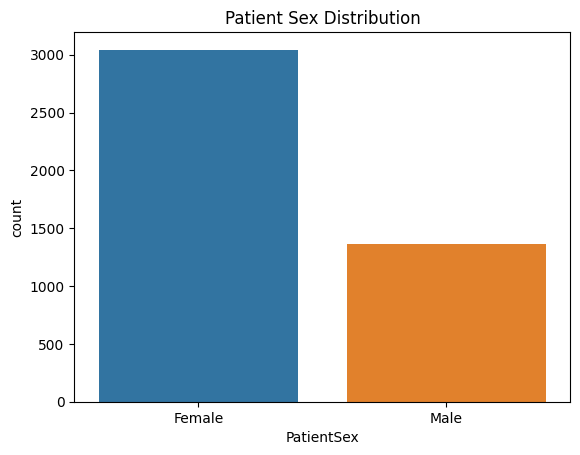

In [8]:
# Group age into bins
train_df['AgeGroup'] = pd.cut(train_df['PatientAge'], bins=[0, 20, 40, 60, 80, 100], labels=["0–20", "21–40", "41–60", "61–80", "81+"])

# Sex distribution
sns.countplot(x="PatientSex", data=train_df)
plt.title("Patient Sex Distribution")
plt.show()


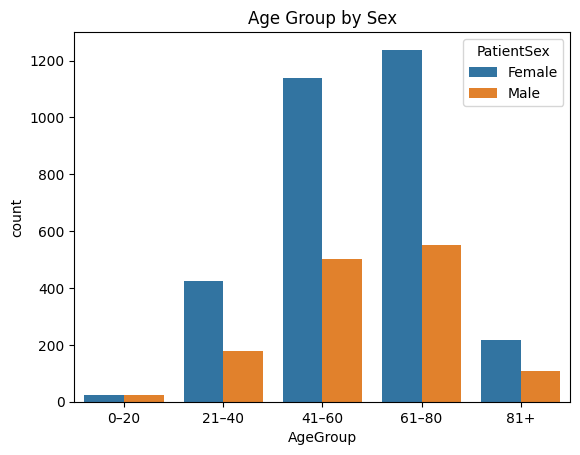

In [9]:
# Age group by sex
sns.countplot(data=train_df, x="AgeGroup", hue="PatientSex")
plt.title("Age Group by Sex")
plt.show()

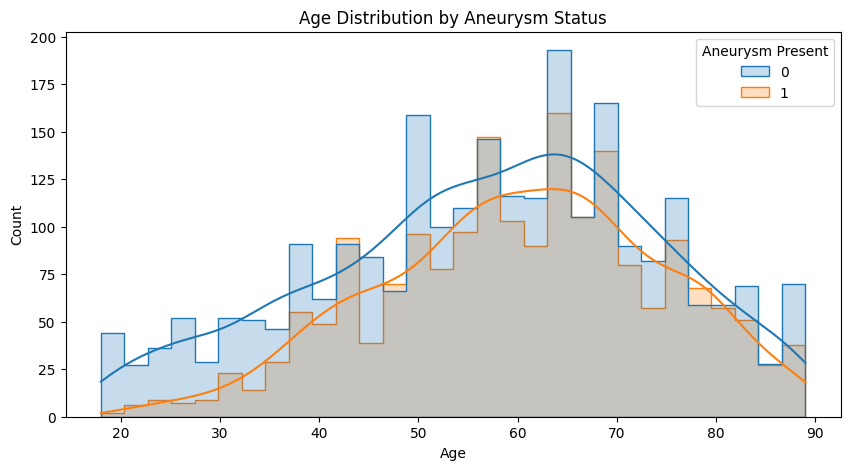

Age stats for aneurysm cases:
 count    1893.000000
mean       60.316957
std        14.201023
min        20.000000
25%        51.000000
50%        61.000000
75%        70.000000
max        89.000000
Name: PatientAge, dtype: float64

Age stats for non-aneurysm cases:
 count    2512.000000
mean       57.074841
std        16.856268
min        18.000000
25%        45.000000
50%        59.000000
75%        69.000000
max        89.000000
Name: PatientAge, dtype: float64


In [10]:
# Age Distribution by Aneurysm Status
import seaborn as sns
import matplotlib.pyplot as plt

# Convert age to numeric (handling possible string entries)
train_df['PatientAge'] = pd.to_numeric(train_df['PatientAge'], errors='coerce')

# Plot age distribution
plt.figure(figsize=(10, 5))
sns.histplot(data=train_df, x='PatientAge', hue='Aneurysm Present', 
             bins=30, kde=True, element='step', palette=['#1f77b4', '#ff7f0e'])
plt.title('Age Distribution by Aneurysm Status')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# Statistical summary
print("Age stats for aneurysm cases:\n", train_df[train_df['Aneurysm Present'] == 1]['PatientAge'].describe())
print("\nAge stats for non-aneurysm cases:\n", train_df[train_df['Aneurysm Present'] == 0]['PatientAge'].describe())

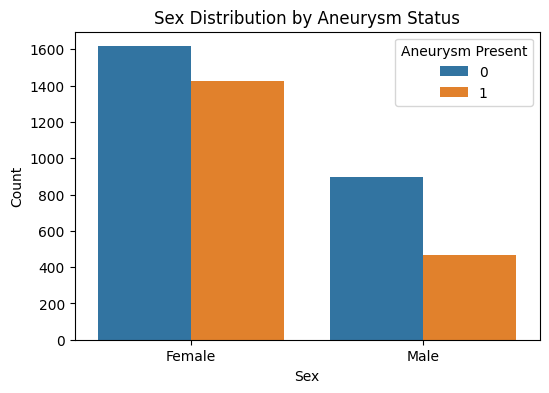

Aneurysm Present     0     1  Total
PatientSex                         
Female            1616  1427   3043
Male               896   466   1362
Total             2512  1893   4405


In [11]:
# Sex Distribution by Aneurysm Status
# Plot sex distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=train_df, x='PatientSex', hue='Aneurysm Present', 
              palette=['#1f77b4', '#ff7f0e'])
plt.title('Sex Distribution by Aneurysm Status')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

# Cross-tabulation
print(pd.crosstab(train_df['PatientSex'], train_df['Aneurysm Present'], 
      margins=True, margins_name="Total"))

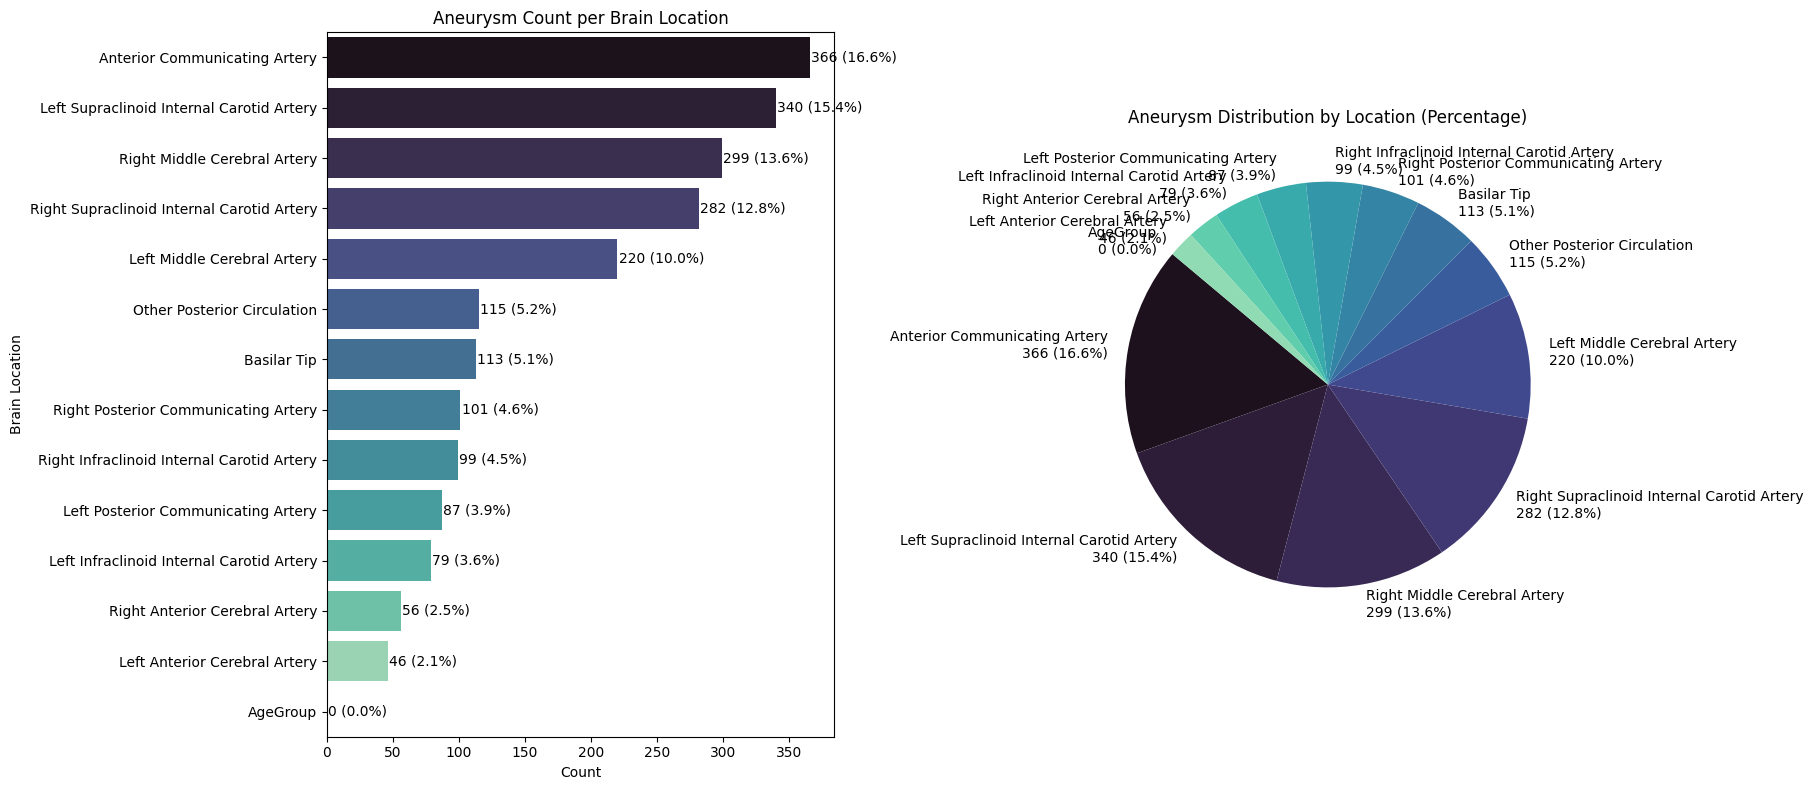

In [12]:

# Get location columns
location_cols = [col for col in train_df.columns if col not in ['SeriesInstanceUID', 'PatientAge', 'PatientSex', 'Modality', 'Aneurysm Present']]

# Convert to numeric if not already
train_df[location_cols] = train_df[location_cols].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)

# Calculate count and percentage
location_counts = train_df[location_cols].sum().sort_values(ascending=False)
location_percentages = location_counts / location_counts.sum() * 100

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Bar chart
sns.barplot(x=location_counts.values, y=location_counts.index, ax=axes[0], palette='mako')
axes[0].set_title("Aneurysm Count per Brain Location")
axes[0].set_xlabel("Count")
axes[0].set_ylabel("Brain Location")

# Annotate with count and percentage
for i, (count, percent) in enumerate(zip(location_counts.values, location_percentages.values)):
    axes[0].text(count + 1, i, f"{int(count)} ({percent:.1f}%)", va='center')

# Pie chart
axes[1].pie(location_counts.values,
            labels=[f"{loc}\n{val} ({pct:.1f}%)" for loc, val, pct in zip(location_counts.index, location_counts.values, location_percentages.values)],
            autopct=None,
            startangle=140,
            colors=sns.color_palette("mako", len(location_counts)))
axes[1].set_title("Aneurysm Distribution by Location (Percentage)")

plt.tight_layout()
plt.show()


### localizer.csv

In [13]:
import ast
# Convert string coordinates to dictionaries
localizers_df['coords'] = localizers_df['coordinates'].apply(ast.literal_eval)

In [14]:
# Extract x, y, z coordinates
localizers_df['x'] = localizers_df['coords'].apply(lambda x: x.get('x', np.nan))
localizers_df['y'] = localizers_df['coords'].apply(lambda x: x.get('y', np.nan))
print(localizers_df[['SeriesInstanceUID', 'SOPInstanceUID', 'location', 'x', 'y']].head())

                                                  SeriesInstanceUID  \
0  1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317   
1  1.2.826.0.1.3680043.8.498.10022796280698534221758473208024838831   
2  1.2.826.0.1.3680043.8.498.10023411164590664678534044036963716636   
3  1.2.826.0.1.3680043.8.498.10030095840917973694487307992374923817   
4  1.2.826.0.1.3680043.8.498.10034081836061566510187499603024895557   

                                                     SOPInstanceUID  \
0  1.2.826.0.1.3680043.8.498.10775329348174902199350466348663848346   
1  1.2.826.0.1.3680043.8.498.53868409774237283281776807176852774246   
2  1.2.826.0.1.3680043.8.498.24186535344744886473554579401056227253   
3  1.2.826.0.1.3680043.8.498.75217084841854214544099244823406151875   
4  1.2.826.0.1.3680043.8.498.71237104731452368587327801789352569583   

                                     location           x           y  
0                 Other Posterior Circulation  258.362119  261.359900  
1 

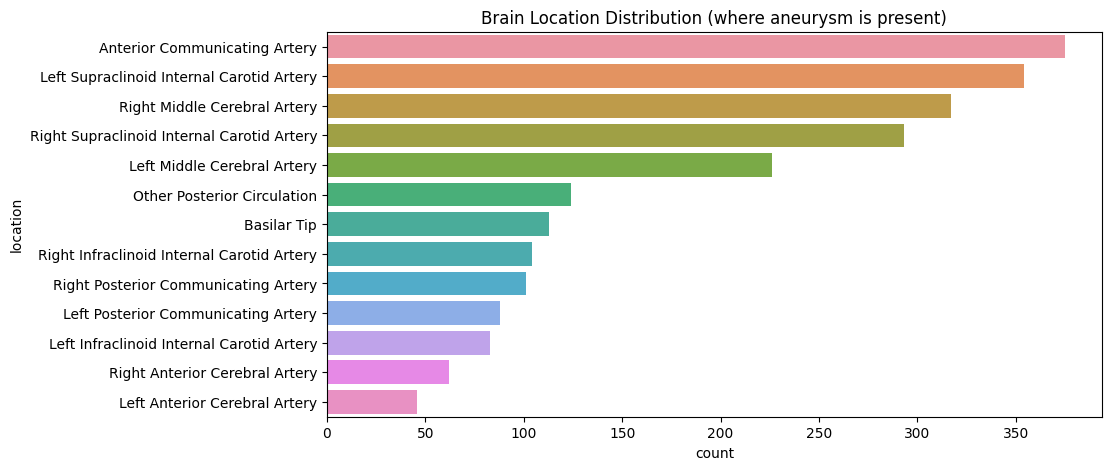

In [15]:
# Analyze Location Distribution
plt.figure(figsize=(10, 5))
sns.countplot(y="location", data=localizers_df, order=localizers_df['location'].value_counts().index)
plt.title("Brain Location Distribution (where aneurysm is present)")
plt.show()


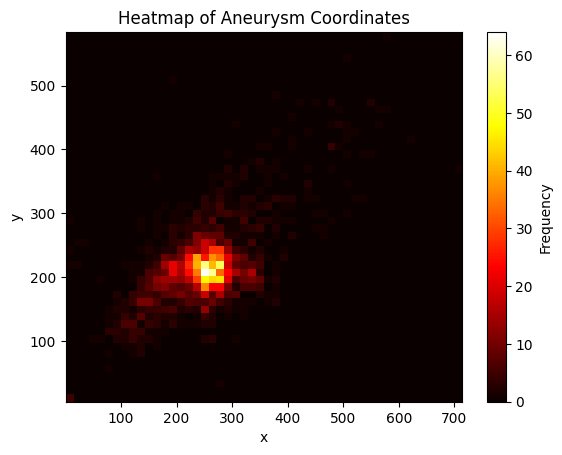

In [16]:
# Heatmap of Coordinate Densities
heatmap_data = localizers_df[['x', 'y']].dropna()

plt.hist2d(heatmap_data['x'], heatmap_data['y'], bins=50, cmap='hot')
plt.colorbar(label='Frequency')
plt.title("Heatmap of Aneurysm Coordinates")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [17]:
# Merge with aneurysm labels
# merged_df = localizers_df.merge(train_df[['SeriesInstanceUID', 'Aneurysm Present']], 
#                                on='SeriesInstanceUID', how='left')

merged_df = pd.merge(train_df, localizers_df, on='SeriesInstanceUID', how='left')


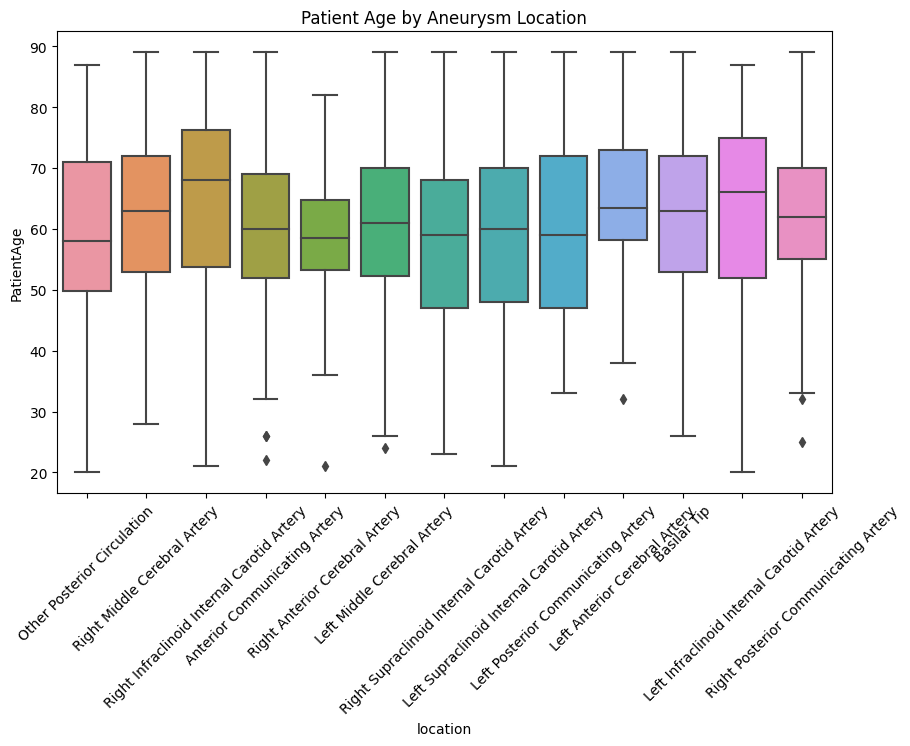

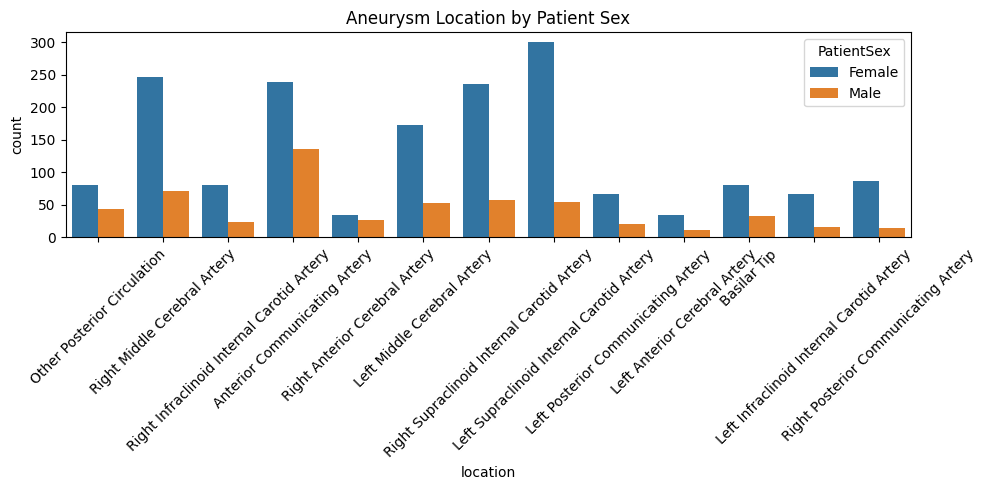

In [18]:
# Age vs Location
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_df, x='location', y='PatientAge')
plt.xticks(rotation=45)
plt.title("Patient Age by Aneurysm Location")
plt.show()

# Sex vs Location
plt.figure(figsize=(10, 5))
sns.countplot(data=merged_df, x='location', hue='PatientSex')
plt.xticks(rotation=45)
plt.title("Aneurysm Location by Patient Sex")
plt.tight_layout()
plt.show()

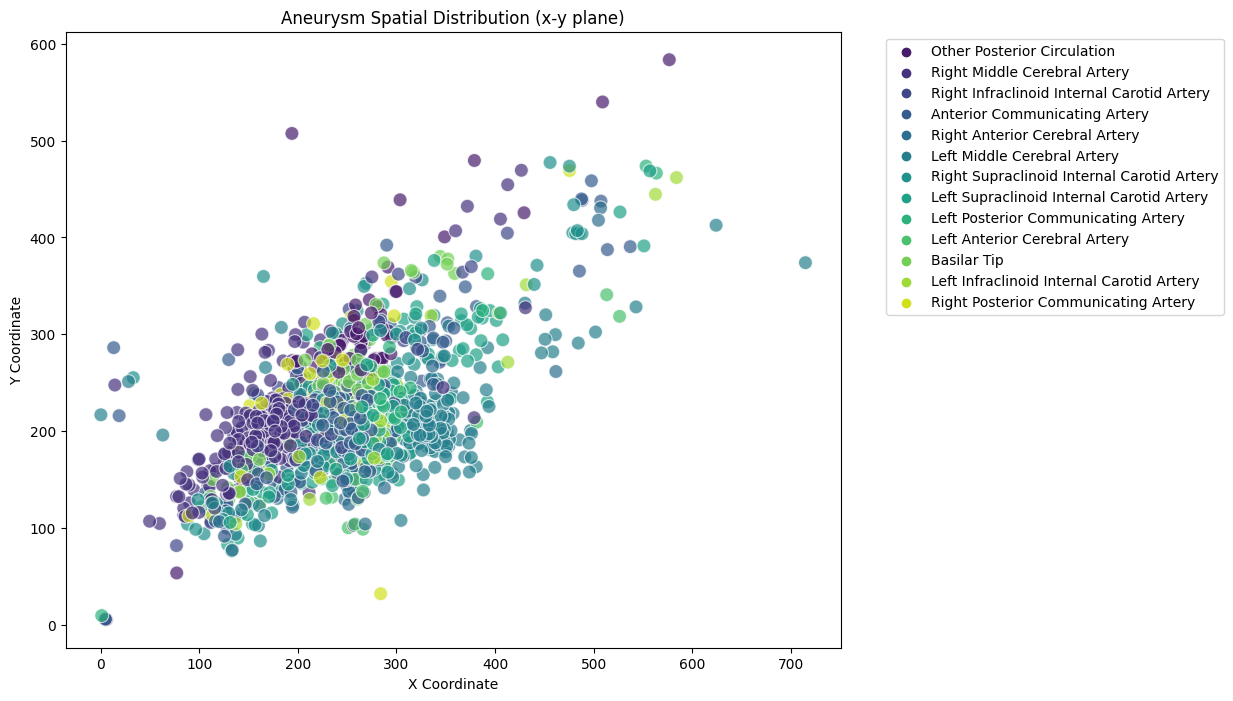

In [19]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=merged_df[merged_df['Aneurysm Present'] == 1], 
                x='x', y='y', hue='location', palette='viridis', s=100, alpha=0.7)
plt.title('Aneurysm Spatial Distribution (x-y plane)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

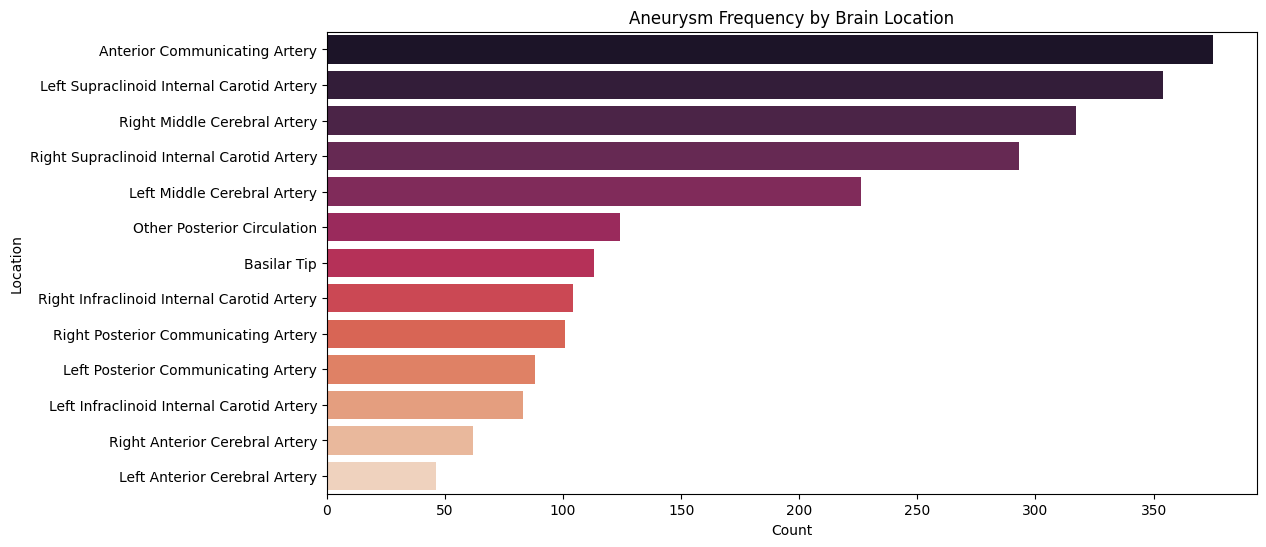

In [20]:
# Brain Location Frequency
# Count aneurysms per brain location
location_counts = merged_df[merged_df['Aneurysm Present'] == 1]['location'].value_counts()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=location_counts.values, y=location_counts.index, palette='rocket')
plt.title('Aneurysm Frequency by Brain Location')
plt.xlabel('Count')
plt.ylabel('Location')
plt.show()

In [21]:
merged_df.columns

Index(['SeriesInstanceUID', 'PatientAge', 'PatientSex', 'Modality',
       'Left Infraclinoid Internal Carotid Artery',
       'Right Infraclinoid Internal Carotid Artery',
       'Left Supraclinoid Internal Carotid Artery',
       'Right Supraclinoid Internal Carotid Artery',
       'Left Middle Cerebral Artery', 'Right Middle Cerebral Artery',
       'Anterior Communicating Artery', 'Left Anterior Cerebral Artery',
       'Right Anterior Cerebral Artery', 'Left Posterior Communicating Artery',
       'Right Posterior Communicating Artery', 'Basilar Tip',
       'Other Posterior Circulation', 'Aneurysm Present', 'AgeGroup',
       'SOPInstanceUID', 'coordinates', 'location', 'coords', 'x', 'y'],
      dtype='object')

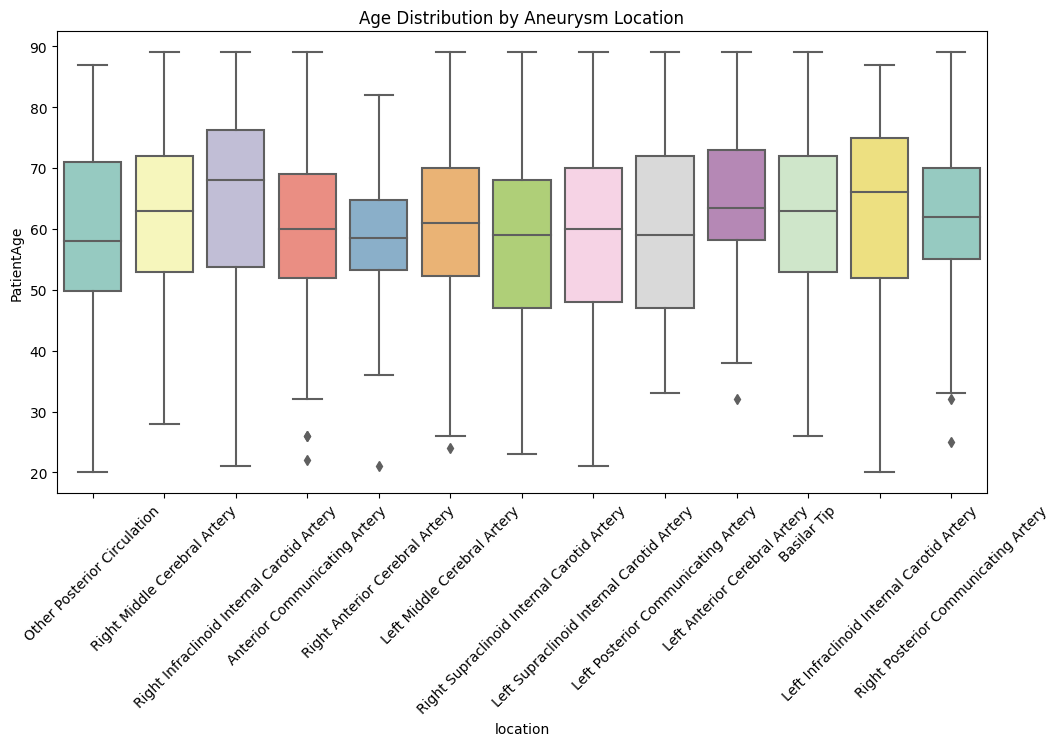

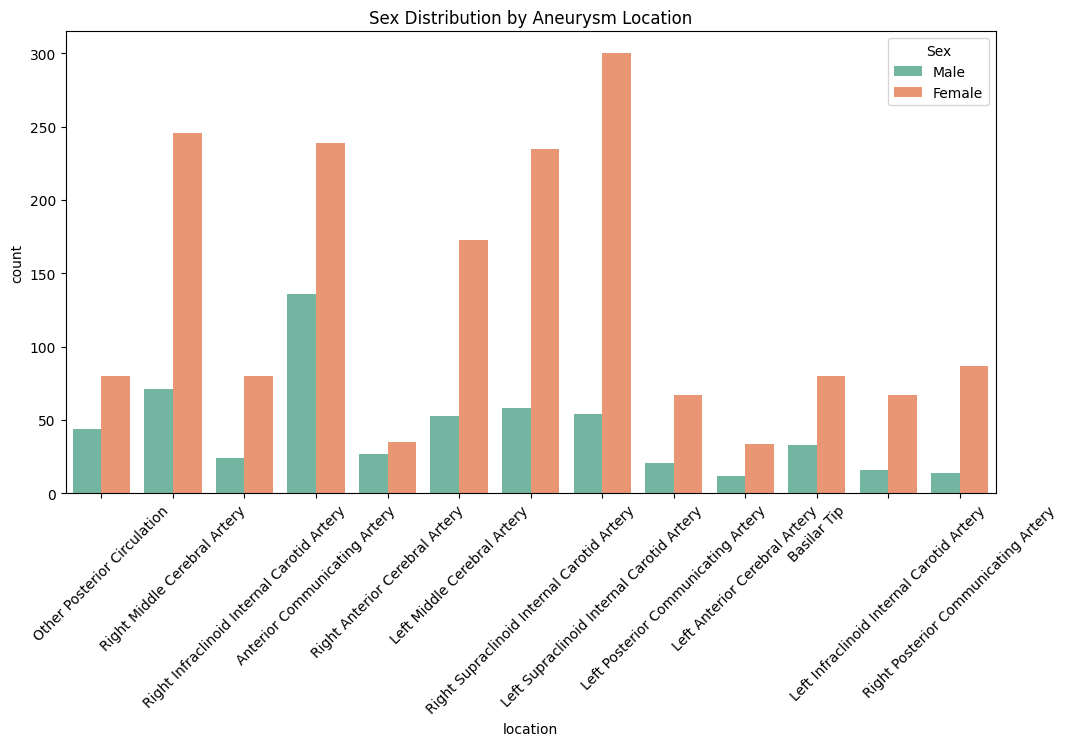

In [22]:
# Age distribution by location
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_df[merged_df['Aneurysm Present'] == 1], 
            x='location', y='PatientAge', palette='Set3')
plt.title('Age Distribution by Aneurysm Location')
plt.xticks(rotation=45)
plt.show()

# Sex distribution by location
plt.figure(figsize=(12, 6))
sns.countplot(data=merged_df[merged_df['Aneurysm Present'] == 1], 
              x='location', hue='PatientSex', palette='Set2')
plt.title('Sex Distribution by Aneurysm Location')
plt.xticks(rotation=45)
plt.legend(title='Sex')
plt.show()